In [7]:

import os
import torch
import torchvision

from tqdm import tqdm
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders

DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")
device = os.environ["DEVICE"]

config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "save_path": os.path.join(DATA_PATH, "models", "imagenet_decoder.pt"),
    "train": True,
}

config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": 128,
    "sessions": list(range(1, 23)),
    # "sessions": [6],
    # "resize_stim_to": (36, 64),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
}

data_loader = get_brainreader_mouse_dataloaders(config['data']['brainreader_mouse'])["brainreader_mouse"]

dl = data_loader["train"]
print("Batches: ", len(dl))
batch = next(dl)
print("Batch length: ", len(batch))
print(batch[0].keys())


Batches:  792
Batch length:  1
dict_keys(['data_key', 'stim', 'resp', 'neuron_coords', 'pupil_center'])


In [ ]:
def stim_to_resnet(stim):
    RESNET_SIZE = 224
    padded_image = torch.zeros(stim.shape[0], 3, RESNET_SIZE, RESNET_SIZE)

    h,w = stim.shape[2:]
    start_h, start_w = (final_size-h)//2, (final_size-w)//2
    stim_color = stim.repeat(1, 3, 1, 1)
    padded_image[:, :, start_h:start_h+h, start_w: start_w + w] = stim_color
    return padded_image

In [ ]:

resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
resnet50.eval().to(device)


batch = next(dl)
assert len(batch) == 1
data = batch[0]

stim = data['stim']
resp = data['resp']
for key in ['stim', 'resp']:
    print(f"{key}: ", data[key].shape)

padded_image = torch.zeros(stim.shape[0], 3, 224, 224)

final_size = 224
h,w = stim.shape[2:]
start_h, start_w = (final_size-h)//2, (final_size-w)//2
stim_color = stim.repeat(1, 3, 1, 1)
padded_image[:, :, start_h:start_h+h, start_w: start_w + w] = stim_color


with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(padded_image), dim=1)
    results = utils.pick_n_best(predictions=output, n=3)
# Convert first 3 to pil and show in jupyter

Using cache found in /home/miki/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/miki/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


stim:  torch.Size([128, 1, 36, 64])
resp:  torch.Size([128, 8739])
tensor([[1.2993e-04, 2.3739e-04, 6.3193e-05,  ..., 1.0322e-04, 1.4568e-04,
         1.2323e-03],
        [2.2771e-04, 2.2587e-04, 1.3034e-04,  ..., 1.4745e-04, 2.4526e-04,
         9.1644e-03],
        [1.0290e-04, 1.1959e-04, 7.2985e-05,  ..., 5.7661e-05, 1.4525e-04,
         1.0341e-02],
        ...,
        [1.1125e-04, 1.6195e-04, 1.0541e-04,  ..., 1.6998e-04, 2.9507e-04,
         1.8188e-03],
        [1.2344e-04, 1.0498e-04, 1.0975e-04,  ..., 2.7633e-04, 3.4397e-04,
         5.1800e-03],
        [8.3574e-05, 1.5035e-04, 5.8956e-05,  ..., 1.0086e-04, 2.2528e-04,
         1.0230e-03]])


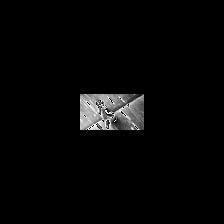

In [14]:
[torchvision.transforms.functional.to_pil_image(padded_image[i, ...]) for i in range(3)]
torchvision.transforms.functional.to_pil_image(padded_image[87, ...])

In [29]:
len(resnet50.layers)

4

In [34]:
# 3. layer has index 2
resnet50.layers[2][0].downsample[0].register_forward_hook(lambda self, input, output: print(output.shape))

In [35]:
with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(padded_image), dim=1)
    results = utils.pick_n_best(predictions=output, n=3)

torch.Size([128, 1024, 14, 14])
sample 0: [('lampshade, lamp shade', '13.3%'), ('table lamp', '5.4%'), ('medicine chest, medicine cabinet', '5.2%')]
sample 1: [('hook, claw', '11.7%'), ('safety pin', '5.7%'), ('lampshade, lamp shade', '5.2%')]
sample 2: [('wall clock', '20.0%'), ('switch, electric switch, electrical switch', '11.6%'), ('thimble', '6.3%')]
sample 3: [('wall clock', '14.5%'), ('book jacket, dust cover, dust jacket, dust wrapper', '9.1%'), ('spotlight, spot', '5.5%')]
sample 4: [('matchstick', '10.7%'), ('book jacket, dust cover, dust jacket, dust wrapper', '3.3%'), ('wall clock', '3.3%')]
sample 5: [('wall clock', '12.0%'), ('switch, electric switch, electrical switch', '5.4%'), ('refrigerator, icebox', '3.8%')]
sample 6: [('web site, website, internet site, site', '9.2%'), ('tripod', '8.2%'), ('reflex camera', '7.2%')]
sample 7: [('can opener, tin opener', '21.1%'), ('safety pin', '3.6%'), ('hair slide', '2.6%')]
sample 8: [('refrigerator, icebox', '7.6%'), ('dishwasher